In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar

In [2]:
df = pd.read_csv('outputs/results_D3/performance_summary_table.csv')
df = df[df['Número de Vértices'] >= 10000].copy()
n_data = df['Número de Vértices'].values
t_dijkstra = df['Tempo Dijkstra (ms)'].values / 1000
t_bmspp = df['Tempo BMSPP (ms)'].values / 1000
# print(df)

In [3]:
# Dijkstra: n * log10(n)
# def model_dijkstra(n, c1, c2, c3, k):
#     return c1 * (n * np.log10(n)) + c2 * n + c3 * np.log10(n) + k
def model_dijkstra(n, c, k):
    return c * (n * np.log10(n)) + k

# BMSPP: n * (log10(n))^(2/3)
# def model_bmspp(n, c1, c2, c3, k):
#     return c1 * (n * np.power(np.log10(n), 2/3)) + c2 * n + c3 * np.log10(n) + k
def model_bmspp(n, c, k):
    return c * (n * np.power(np.log10(n), 2/3)) + k

# --- 3. CURVE FITTING ---
# We use bounds=(0, np.inf) to ensure coefficients are positive
params_d, _ = curve_fit(model_dijkstra, n_data, t_dijkstra, bounds=(0, np.inf))
params_b, _ = curve_fit(model_bmspp, n_data, t_bmspp, bounds=(0, np.inf))

c_d, k_d = params_d
c_b, k_b = params_b

print("--- Fit Results (Base 10) ---")
print(f"Dijkstra: {c_d:.2e} * n log10(n) + {k_d:.2f}")
print(f"BMSPP:    {c_b:.2e} * n (log10 n)^(2/3) + {k_b:.2f}")

--- Fit Results (Base 10) ---
Dijkstra: 8.50e-08 * n log10(n) + 0.00
BMSPP:    6.10e-07 * n (log10 n)^(2/3) + 0.00


In [4]:
# Solving for x = log10(n) where Dijkstra(n) = BMSPP(n)
def intersection_func(x):
    # 10^x is used because x is now log10(n)
    # ten_to_x = np.power(10.0, x)
    # return (c_d * x - c_b * np.power(x, 2/3)) + (k_d - k_b) / ten_to_x
    return (c_d * x) - (c_b * np.power(x, 2/3))

low_x = np.log10(2)
high_x = 400.0 

try:
    sol = root_scalar(intersection_func, bracket=[low_x, high_x], method='brentq')
    
    if sol.converged:
        x_intersect = sol.root
        # n_intersect = np.power(10.0, x_intersect)
        print(f"Crossover found at log10(n) ≈ {x_intersect:.2f}")
        print(f"Estimated Vertices (n): 10^{x_intersect:.2f}")
except ValueError:
    f_low = intersection_func(low_x)
    f_high = intersection_func(high_x)
    print("--- Analysis ---")
    if f_low > 0 and f_high > 0:
        print("BMSPP is already faster.")
    elif f_low < 0 and f_high < 0:
        print(f"Dijkstra is faster throughout the range (up to 10^{high_x}).")

Crossover found at log10(n) ≈ 369.79
Estimated Vertices (n): 10^369.79


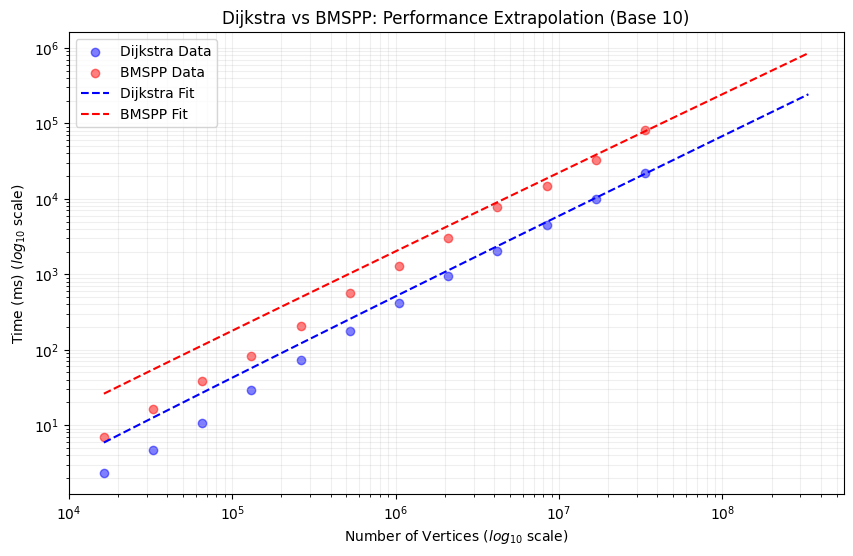

In [5]:
# --- 5. VISUALIZATION ---
plt.figure(figsize=(10, 6))

# Plot raw data (Multiply by 1000 if you want to show ms on the axis)
plt.scatter(n_data, t_dijkstra * 1000, label='Dijkstra Data', color='blue', alpha=0.5)
plt.scatter(n_data, t_bmspp * 1000, label='BMSPP Data', color='red', alpha=0.5)

# Generate fit lines
n_plot = np.geomspace(n_data[0], n_data[-1] * 10, 100)
plt.plot(n_plot, model_dijkstra(n_plot, *params_d) * 1000, 'b--', label='Dijkstra Fit')
plt.plot(n_plot, model_bmspp(n_plot, *params_b) * 1000, 'r--', label='BMSPP Fit')

plt.xscale('log') # Default is base 10
plt.yscale('log') # Default is base 10
plt.xlabel('Number of Vertices ($log_{10}$ scale)')
plt.ylabel('Time (ms) ($log_{10}$ scale)') # Fixed the label to match the 1000x multiplier
plt.title('Dijkstra vs BMSPP: Performance Extrapolation (Base 10)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [ ]:
# --- 8. POWER-LAW MODEL INTERSECTION ANALYSIS ---

# 1. Define Power-Law Model
# t = c * n^a + k
def model_power_law(n, c, a, k):
    return c * np.power(n, a) + k

# 2. Fit the Models
# Initial guesses: c (very small), a (near 1.0 for Dijkstra), k (offset)
p0_power = [1e-9, 1.0, 0.01]
params_d_pow, _ = curve_fit(model_power_law, n_data, t_dijkstra, p0=p0_power, bounds=(0, np.inf))
params_b_pow, _ = curve_fit(model_power_law, n_data, t_bmspp, p0=p0_power, bounds=(0, np.inf))

# 3. Define the Normalized Intersection Function
def intersection_func_power(x):
    """
    We solve for where (Dijkstra / BMSPP) = 1.
    In log space: log10(Dijkstra) - log10(BMSPP) = 0
    To handle the 'k' constant safely, we use the property:
    log(c*n^a + k) = log(c*n^a * (1 + k/(c*n^a))) = log(c) + a*log(n) + log(1 + k/(c*n^a))
    """
    cd, ad, kd = params_d_pow
    cb, ab, kb = params_b_pow
    
    # log10(c * n^a + k)
    # As n becomes huge, k becomes irrelevant, but we keep it for small n:
    def safe_log_power(c, a, k, x_val):
        # term = k / (c * 10^(a*x))
        # log_term = log10(k) - (log10(c) + a*x)
        log_c_na = np.log10(c) + a * x_val
        ratio = k / np.power(10, log_c_na) if log_c_na < 300 else 0
        return log_c_na + np.log10(1 + ratio)

    return safe_log_power(cd, ad, kd, x) - safe_log_power(cb, ab, kb, x)

# 4. Search for Intersection
low_x = np.log10(n_data[0])
high_x = 1000.0  # Search up to 10^1000

print("--- Power-Law Model Fit Results ---")
print(f"Dijkstra: {params_d_pow[0]:.2e} * n^{params_d_pow[1]:.4f} + {params_d_pow[2]:.4f}")
print(f"BMSPP:    {params_b_pow[0]:.2e} * n^{params_b_pow[1]:.4f} + {params_b_pow[2]:.4f}\n")

try:
    sol = root_scalar(intersection_func_power, bracket=[low_x, high_x], method='brentq')
    
    if sol.converged:
        x_intersect = sol.root
        
        # Calculate log10(Time) at intersection
        cd, ad, kd = params_d_pow
        log10_time = np.log10(cd) + ad * x_intersect
        
        print(f"--- Power-Law Intersection Found ---")
        print(f"Crossover Point: log10(n) ≈ {x_intersect:.2f}")
        print(f"Estimated Vertices (n): 10^{x_intersect:.2f}")
        print(f"Estimated Execution Time: 10^{log10_time:.2f} seconds")

except ValueError:
    f_high = intersection_func_power(high_x)
    print("--- No Intersection Found ---")
    if f_high > 0:
        print(f"BMSPP becomes faster than Dijkstra within the range 10^{high_x}.")
    else:
        print(f"Dijkstra remains faster than BMSPP for the entire range (up to 10^{high_x}).")

--- Complex Model Parameters ---
Dijkstra coefficients: c1=8.50e-08, c2=2.81e-28, c3=1.14e-22, k=0.0000
BMSPP coefficients:    c1=6.10e-07, c2=8.07e-33, c3=1.12e-24, k=0.0000

--- Intersection Found (Overflow-Safe) ---
Crossover log10(n): 369.79
Vertices (n): 10^369.79
Log10 of execution time (seconds): 365.29


In [7]:
from sklearn.metrics import r2_score

# --- 6. ACCURACY COMPARISON ---

# Predictions for the original data points
pred_d_log = model_dijkstra(n_data, *params_d)
pred_d_pow = model_power_law(n_data, *params_d_pow)

pred_b_log = model_bmspp(n_data, *params_b)
pred_b_pow = model_power_law(n_data, *params_b_pow)

# Calculate R^2 scores
r2_d_log = r2_score(t_dijkstra, pred_d_log)
r2_d_pow = r2_score(t_dijkstra, pred_d_pow)

r2_b_log = r2_score(t_bmspp, pred_b_log)
r2_b_pow = r2_score(t_bmspp, pred_b_pow)

print("--- R^2 Accuracy Scores (Higher is Better) ---")
print(f"Dijkstra (n log n): {r2_d_log:.5f}")
print(f"Dijkstra (Power Law): {r2_d_pow:.5f}")
print("-" * 30)
print(f"BMSPP (n log n^2/3): {r2_b_log:.5f}")
print(f"BMSPP (Power Law):    {r2_b_pow:.5f}")

NameError: name 'model_power_law' is not defined

In [ ]:
# --- 7. COMPLEX MODEL INTERSECTION ANALYSIS ---

# 1. Define the Complex Models (Keep these as is)
def model_complex_dijkstra(n, c1, c2, c3, k):
    return c1 * (n * np.log10(n)) + c2 * n + c3 * np.log10(n) + k

def model_complex_bmspp(n, c1, c2, c3, k):
    return c1 * (n * np.power(np.log10(n), 2/3)) + c2 * n + c3 * np.log10(n) + k

# 2. Fit the Models
p0_guess = [1e-9, 1e-9, 1e-9, 0.01] 
params_d_comp, _ = curve_fit(model_complex_dijkstra, n_data, t_dijkstra, p0=p0_guess, bounds=(0, np.inf))
params_b_comp, _ = curve_fit(model_complex_bmspp, n_data, t_bmspp, p0=p0_guess, bounds=(0, np.inf))

# 3. Define the Intersection Function (Normalized to avoid overflow)
def intersection_func_complex(x):
    """
    We solve for where (Dijkstra - BMSPP) / 10^x = 0
    This removes the 10^x term that causes overflow.
    """
    cd1, cd2, cd3, kd = params_d_comp
    cb1, cb2, cb3, kb = params_b_comp
    
    # 10^-x is safe even for large x (it simply approaches 0)
    ten_to_neg_x = np.power(10.0, -x)
    
    # Normalized Models (model / 10^x):
    # c1*x + c2 + (c3*x + k) * 10^-x
    d_norm = cd1 * x + cd2 + (cd3 * x + kd) * ten_to_neg_x
    b_norm = cb1 * np.power(x, 2/3) + cb2 + (cb3 * x + kb) * ten_to_neg_x
    
    return d_norm - b_norm

# 4. Search for Intersection
low_x = np.log10(n_data[0])
high_x = 400.0  # Search range up to 10^400 vertices

print("--- Complex Model Fit Results ---")
print(f"Dijkstra: {params_d_comp[0]:.2e}(n log n) + {params_d_comp[1]:.2e}(n) + {params_d_comp[2]:.2e}(log n) + {params_d_comp[3]:.4f}")
print(f"BMSPP:    {params_b_comp[0]:.2e}(n log^2/3 n) + {params_b_comp[1]:.2e}(n) + {params_b_comp[2]:.2e}(log n) + {params_b_comp[3]:.4f}\n")

try:
    # Use Brent's method on the normalized function
    sol = root_scalar(intersection_func_complex, bracket=[low_x, high_x], method='brentq')
    
    if sol.converged:
        x_intersect = sol.root
        
        # Calculate log10(Time) safely to avoid overflow in the final display
        # Time = 10^x * d_norm  =>  log10(Time) = x + log10(d_norm)
        cd1, cd2, cd3, kd = params_d_comp
        ten_to_neg_x = np.power(10.0, -x_intersect)
        d_norm = cd1 * x_intersect + cd2 + (cd3 * x_intersect + kd) * ten_to_neg_x
        log10_time = x_intersect + np.log10(d_norm)
        
        print(f"--- Intersection Found ---")
        print(f"Crossover Point: log10(n) ≈ {x_intersect:.2f}")
        print(f"Estimated Vertices (n): 10^{x_intersect:.2f}")
        print(f"Estimated Execution Time: 10^{log10_time:.2f} seconds")
except ValueError:
    f_high = intersection_func_complex(high_x)
    print("--- No Intersection Found ---")
    if f_high < 0:
        print(f"Dijkstra remains faster than BMSPP for the entire range (up to 10^{high_x}).")
    else:
        print(f"BMSPP is already faster than Dijkstra within the data range.")

--- Complex Model Fit Results ---
Dijkstra: 8.50e-08(n log n) + 2.81e-28(n) + 1.14e-22(log n) + 0.0000
BMSPP:    6.10e-07(n log^2/3 n) + 8.07e-33(n) + 1.12e-24(log n) + 0.0000



/tmp/ipykernel_11355/1255394556.py:20: RuntimeWarning: overflow encountered in power
  n_val = np.power(10.0, x)
/tmp/ipykernel_11355/1255394556.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  return model_complex_dijkstra(n_val, *params_d_comp) - model_complex_bmspp(n_val, *params_b_comp)
